# Digitize Your Chart Recorder Plot
### Victoria Catlett
### Derived from https://www.linuxtut.com/en/fd1d6eeb395cf572d6a2/

### Step 1: Import Packages
Import all of the packages you need. If you get an error from this cell, that means you're missing a package. All you have to do is ```pip install``` it, then maybe restart Jupyter Notebook (if the error persists after installation).

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
import requests
from PIL import Image
import io
%matplotlib inline

### Step 2: Read in the Image
```path``` should be set to the path to the image you want. If it's in the same directory (folder) as this Jupyter Notebook, then all you have to do is put the image name. 

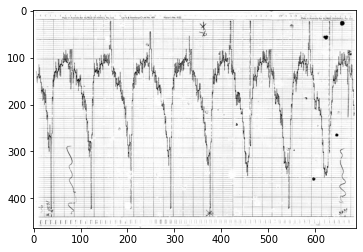

In [22]:
path = 'sample-chart-recorder.png'
im = plt.imread(path)
if im.shape[2] == 4:im = im[:,:,:-1]
if im.max() > 1:im /= 255
h, w, _ = im.shape
plt.imshow(im)

### Step 3: Crop the Image
Crop the image using the sliders that are generated when you run the next cell. Make sure only the data (not axis labels or anything) is in the cropped image. 

In [31]:
@interact(x_min=(0, w), x_max=(0, w), y_min=(0,h), y_max=(0,h))
def Plot(x_min=0, x_max=w, y_min=0, y_max=h):
    global imag
    plt.figure(figsize=(7, 7))
    imag = im[min(y_min,y_max-1):max(y_min+1, y_max), min(x_min,x_max-1):max(x_min+1, x_max)]
    plt.imshow(imag)

interactive(children=(IntSlider(value=0, description='x_min', max=688), IntSlider(value=688, description='x_ma…

### Step 4: Isolate the Data
Run the cell below, then use the ```x``` and ```y``` sliders below to center the red crosshairs on the data. What this will do is select only the pixels matching that color (within a certain range, determined by ```threshold```). Pixels meeting this criteria will be lighter colors in the plot. Play around with this until you like what's left.  

In [32]:
@interact(x=(0, imag.shape[1]), y=(0,imag.shape[0]), thresh=(1,10))
def Plot(x, y, thresh):
    global p
    p = ((imag - imag[y, x]) ** 2).sum(axis=2) < (1 / (1<<thresh))
    print(p.sum())
    plt.imshow(p)
    plt.plot([x, x], [0, imag.shape[0]], color="r")
    plt.plot([0, imag.shape[1]], [imag.shape[0]-y, imag.shape[0]-y], color="r")

interactive(children=(IntSlider(value=297, description='x', max=594), IntSlider(value=203, description='y', ma…

### Step 5: Turn this into x and y data
This next cell turns the image into a single curve by averaging the values in each column. 

In [33]:
p = np.pad(p, 1, "constant")
sx = np.arange(len(p[0]))[p.argmax(axis=0)!=0]
sy = []

for i in p.T:
    j = np.where(i!=0)[0]
    if j.tolist():
        sy.append(j.mean())

### Step 6: Filter Data
Run this cell, then play with the sliders to adjust the noise level of the result. 

In [42]:
@interact(sample=(5, 1250), conv_size=(1, 21, 2))
def fit(sample, conv_size):
    global x_fit, y_fit
    plt.figure()
    plt.imshow(imag)
    
    x_fit = np.linspace(sx.min(), sx.max(), sample)
    y_fit = np.convolve(np.pad(np.interp(x, sx, sy), (conv_size-1)//2, "edge"), np.ones(conv_size) / conv_size, "valid")
    plt.plot(x_fit, y_fit, 'r')

interactive(children=(IntSlider(value=627, description='sample', max=1250, min=5), IntSlider(value=11, descrip…

### Step 7: Normalize the Data and Identify Reference Points
Now, let's get this data to actually match your x and y bounds. We'll do so by identifying the highest and lowest points, then scaling accordingly. You may notice that the first part of this cell normalizes the data and flips the y values (a residual necessity from plotting on the image, which has an inverted y axis). 

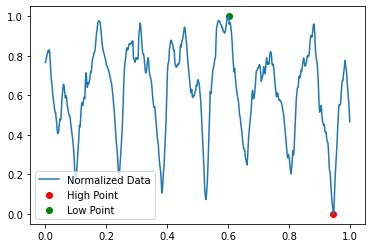

In [64]:
xf_min = np.min(x_fit)
xf_max = np.max(x_fit)
yf_min = np.min(y_fit)
yf_max = np.max(y_fit)

x_norm = [(xi-xf_min)/(xf_max-xf_min) for xi in x_fit]
y_norm = [(yi-yf_max)/(yf_min-yf_max) for yi in y_fit]
low_indx = np.where(y_norm == np.min(y_norm))[0][0]
high_indx = np.where(y_norm == np.max(y_norm))[0][0]
low_pt = [x_norm[low_indx], y_norm[low_indx]]
high_pt = [x_norm[high_indx], y_norm[high_indx]]

plt.figure()
plt.plot(x_norm, y_norm, label='Normalized Data')
plt.scatter(x_norm[low_indx], y_norm[low_indx], color='r', label='High Point')
plt.scatter(x_norm[high_indx], y_norm[high_indx], color='g', label='Low Point')
plt.legend()

### Step 8: Scale the Data
Identify the x and y values of each of the two points, then ADD THEM IN THE CELL BELOW. This cell will then scale the data accordingly. 

40.762790697674426

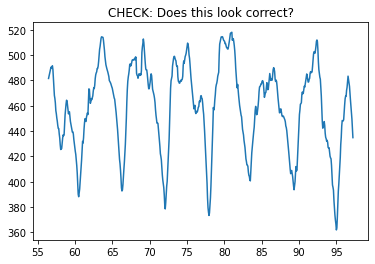

In [82]:
# EDIT THESE FOUR VALUES TO MATCH YOUR DATA
# Lowest Point
TRUE_MIN_X = 95
TRUE_MIN_Y = 362

# HIGHEST POINT
TRUE_MAX_X = 81
TRUE_MAX_Y = 518

# The rest of this cell should stay the same
x_scale = (TRUE_MAX_X - TRUE_MIN_X)/(x_norm[high_indx]-x_norm[low_indx])
y_scale = (TRUE_MAX_Y - TRUE_MIN_Y)/(y_norm[high_indx]-y_norm[low_indx])
x_pre_off = np.min([x_norm[high_indx],x_norm[low_indx]])
x_off = np.min([TRUE_MIN_X, TRUE_MAX_X])
y_off = TRUE_MIN_Y

x_final = [(xn-x_pre_off)*x_scale+x_off for xn in x_norm]
y_final = [yn*y_scale+y_off for yn in y_norm]

plt.figure()
plt.title('CHECK: Does this look correct?')
plt.plot(x_final, y_final)
x_scale

### Step 9: Save the Data
Now, we'll save the data to a CSV file using ```pandas```.

In [83]:
df = pd.DataFrame({'x':x_final, 'y':y_final})
df.to_csv('digitized-data.csv', index=False)